In [2]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

In [3]:
torch.manual_seed(777)

In [7]:
device = torch.device("cuda") if torch.cuda.is_available() else  torch.device("cpu")
device

device(type='cuda')

In [9]:
transformer = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

In [10]:
train_set = torchvision.datasets.MNIST(
    root=".", train=True, download=True, transform=transformer
)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [12]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

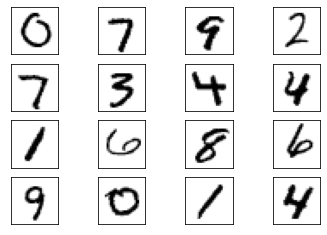

In [13]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

In [14]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

In [16]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

In [17]:
discriminator = Discriminator().to(device=device)
generator = Generator().to(device=device)

In [18]:
lr = 0.0001
num_epochs = 50
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [19]:
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device)
        real_samples_labels = torch.ones((batch_size, 1)).to(device)
        latent_space_samples = torch.randn((batch_size, 100)).to(device)

        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(device)

        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(device)

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.5405079126358032
Epoch: 0 Loss G.: 0.5196197032928467
Epoch: 1 Loss D.: 0.03948341682553291
Epoch: 1 Loss G.: 5.957581043243408
Epoch: 2 Loss D.: 0.008335281163454056
Epoch: 2 Loss G.: 4.822509288787842
Epoch: 3 Loss D.: 0.01884838193655014
Epoch: 3 Loss G.: 5.072187423706055
Epoch: 4 Loss D.: 0.01605389080941677
Epoch: 4 Loss G.: 3.984170436859131
Epoch: 5 Loss D.: 0.020966261625289917
Epoch: 5 Loss G.: 4.411125659942627
Epoch: 6 Loss D.: 0.12134519219398499
Epoch: 6 Loss G.: 4.059779644012451
Epoch: 7 Loss D.: 0.12021685391664505
Epoch: 7 Loss G.: 3.734489917755127
Epoch: 8 Loss D.: 0.18799781799316406
Epoch: 8 Loss G.: 3.073991060256958
Epoch: 9 Loss D.: 0.43789997696876526
Epoch: 9 Loss G.: 2.611363410949707
Epoch: 10 Loss D.: 0.3964182138442993
Epoch: 10 Loss G.: 2.214806079864502
Epoch: 11 Loss D.: 0.36236268281936646
Epoch: 11 Loss G.: 1.3636715412139893
Epoch: 12 Loss D.: 0.49312013387680054
Epoch: 12 Loss G.: 1.7571051120758057
Epoch: 13 Loss D.: 0.39861303

In [20]:
latent_space_samples = torch.randn(batch_size, 100).to(device)
generated_samples = generator(latent_space_samples)

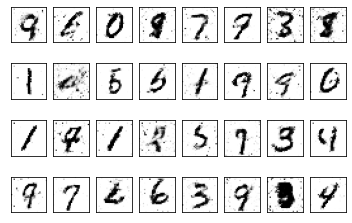

In [25]:
generated_samples = generated_samples.cpu().detach()
for i in range(32):
    ax = plt.subplot(4, 8, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])